## Установка зависимостей

In [ ]:
!pip install -r requirements.txt

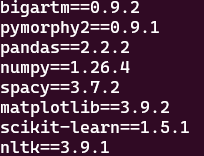

## Импорты

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import artm
from artm import BatchVectorizer
import pymorphy2
import numpy as np
import nltk
from nltk.corpus import stopwords
import spacy
import os
import random
import re

import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dmitry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!python -m spacy download ru_core_news_md

## Установка seed-ов

In [6]:
seed = 42
np.random.seed(seed)
random.seed(seed)

## Инициализация переменных

In [7]:
PATH_TO_TRAIN_DATA = "dataset/train.parquet"
PATH_TO_TEST_DATA = "dataset/test.parquet"
SPACY_RU = spacy.load('ru_core_news_md')
STOPWORDS = set(stopwords.words("russian"))

## Чтение датасета

In [8]:
train_data = pd.read_parquet(PATH_TO_TRAIN_DATA, "pyarrow")
test_data = pd.read_parquet(PATH_TO_TEST_DATA, "pyarrow")

In [9]:
train_data.head()

,text,summary,topic,url,title,date
0,Сладострастник в течение трех лет преследовал ...,Старший преподаватель института коммунального ...,incident,https://www.mk.ru/incident/article/2010/01/05/...,Педофил преследовал подростка три года,06/01/2010
1,Буквально за час до боя курантов в подземном п...,Манежная площадь Москвы стала местом последнег...,incident,https://www.mk.ru/incident/article/2010/01/05/...,Таджики устроили резню на Манежной площади под...,06/01/2010
2,"Там они покатались на лыжах и снегоходах, пооб...",Президент РФ Дмитрий Медведев с семьей проводи...,politics,https://www.mk.ru/politics/article/2010/01/05/...,"""""""За все платит президент""""""",06/01/2010
3,Сосед расстрелял соседа из-за претензий по пов...,Первое убийство в 2010 году произошло в Москве...,incident,https://www.mk.ru/incident/article/2010/01/05/...,Первое убийство года спровоцировал потоп,06/01/2010
4,Причиной трагедии специалисты считают нарушени...,"Шесть человек, в том числе 9-летний ребенок, з...",incident,https://www.mk.ru/incident/article/2010/01/05/...,Целая семья не пережила газовой атаки,06/01/2010


## Обработка текста

In [10]:
def tokenize_fn(s: str) -> list:
    '''
    Токенизация и лемматизация предложения.
    '''
    doc = SPACY_RU(s)
    result = [word.lemma_ for word in doc if word.lemma_ not in STOPWORDS]
    return result

def preprocessing_dataset(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Данная функция осуществляет предобработку датасета.
    '''
    patterns = r"[^\w\s]|[\d_]"
    dataframe = dataframe.drop(["url", "date", "summary", "title"], axis=1, errors="ignore")
    dataframe["text"] = dataframe["text"].apply(
        lambda s: tokenize_fn(re.sub(patterns, "", s.lower().strip()))
    )
    return dataframe

In [11]:
train_data_preprocessed = preprocessing_dataset(train_data)

In [12]:
test_data_preprocessed = preprocessing_dataset(test_data)

In [13]:
train_data_preprocessed.to_csv("train_data_preprocessed.csv", index=False)
test_data_preprocessed.to_csv("test_data_preprocessed.csv", index=False)

### Объясняю как это работает
Допустим, у нас есть список списков `[[], [], ..., []]`, где каждый список внутри это что-то типо такого: `[как, тебя, дела, воыфа]`  

Данный код проходится по спискам внутри и убирает лишние слова (проверяется это функцией `is_valid_russian_word`). После того, как мы убрали лишнее, делаем `join` данного списка

Результат: `[как тебя дела]`

In [16]:
morph = pymorphy2.MorphAnalyzer()

In [17]:
def is_valid_russian_word(word):
    parsed = morph.parse(word)[0]
    allowed_pos = {'NOUN', 'ADJF', 'ADJS', 'VERB', 'INFN', 'ADVB', 'NUMR'}
    return any(pos in parsed.tag for pos in allowed_pos)

In [50]:
train_data_preprocessed["text"] = [" ".join([word for word in list_words.split() if is_valid_russian_word(word)]) for list_words in train_data_preprocessed["text"]]

In [52]:
test_data_preprocessed["text"] = [" ".join([word for word in list_words if is_valid_russian_word(word)]) for list_words in test_data_preprocessed["text"]]

## Создание словаря

In [53]:
vectorizer = CountVectorizer(max_df=0.5,
                             min_df=2,
                             max_features=20000, 
                             ngram_range=(1,3))

train_data_vectorized = vectorizer.fit_transform(train_data_preprocessed["text"].values)
test_data_vectorized = vectorizer.transform(test_data_preprocessed["text"].values)

In [54]:
n_wd = train_data_vectorized.todense().T
test_n_wd = test_data_vectorized.todense().T

In [55]:
print("train_n_wd: {}\ntest_n_wd: {}".format(n_wd.shape, test_n_wd.shape))

train_n_wd: (20000, 25556)
test_n_wd: (20000, 757)


In [58]:
vocabulary = vectorizer.get_feature_names_out()
vocabulary

array(['абитуриент', 'абонемент', 'абонент', ..., 'ёлочка', 'ёлочный',
       'ёмкость'], dtype=object)

In [61]:
if os.path.isdir('train_batches'):
    os.remove("train_batches")

if os.path.isdir('test_batches'):
    os.remove("test_batches")
    
batch_vectorizer = BatchVectorizer(
    data_format = "bow_n_wd",
    n_wd=n_wd,
    vocabulary=vocabulary,
    target_folder="train_batches"
)

test_batch_vectorizer = BatchVectorizer(
    data_format="bow_n_wd",
    n_wd=test_n_wd,
    vocabulary=vocabulary,
    target_folder="test_batches"
)

# LDA

In [62]:
def lda_fit(num_topics: int)  -> dict:
    '''
    Обучение LDA модели с количеством тем = num_topics.
    '''
    lda_model = artm.LDA(
        num_topics=num_topics,
        alpha=0.1,
        beta=0.01,
        cache_theta=True,
        num_document_passes=10,
        dictionary=batch_vectorizer.dictionary
    )

    lda_model.fit_offline(
        batch_vectorizer=batch_vectorizer,
        num_collection_passes=10
    )

    results = {
        "model": lda_model,
        "perplexity_value": lda_model.perplexity_value
    }

    return results

In [63]:
num_topics_list = [5, 10, 15, 20, 25, 30]
fit_results = {}

for num_topics in num_topics_list:
    print("Обучение с количеством тем = {}".format(num_topics))
    fit_result = lda_fit(num_topics)
    fit_results[num_topics] = fit_result

Обучение с количеством тем = 5
Обучение с количеством тем = 10
Обучение с количеством тем = 15
Обучение с количеством тем = 20
Обучение с количеством тем = 25
Обучение с количеством тем = 30


In [64]:
perplexity_values = [(f"{num_topics_list[index]} тем", value["perplexity_value"]) for index, value in enumerate(fit_results.values())]
perplexity_values[0]

('5 тем',
 [19823.76953125,
  6373.69775390625,
  6293.16796875,
  6094.2587890625,
  5795.78125,
  5529.6572265625,
  5350.19580078125,
  5226.5458984375,
  5136.0322265625,
  5069.197265625])

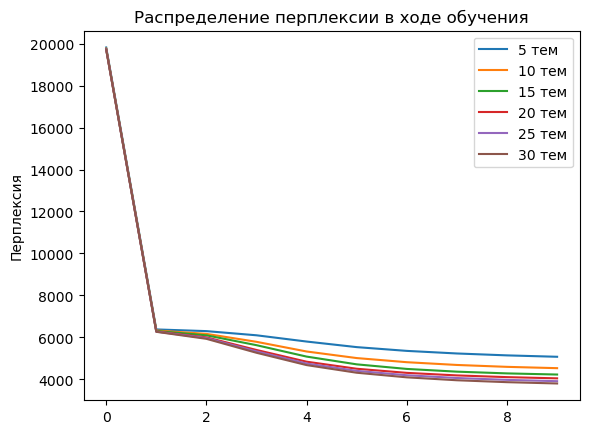

In [65]:
x = np.arange(len(perplexity_values[0][1]))
for num_topics, perplexity_value in perplexity_values:
    sns.lineplot(x=x, y=perplexity_value, label=num_topics)

plt.ylabel("Перплексия")
plt.title("Распределение перплексии в ходе обучения")
plt.show()

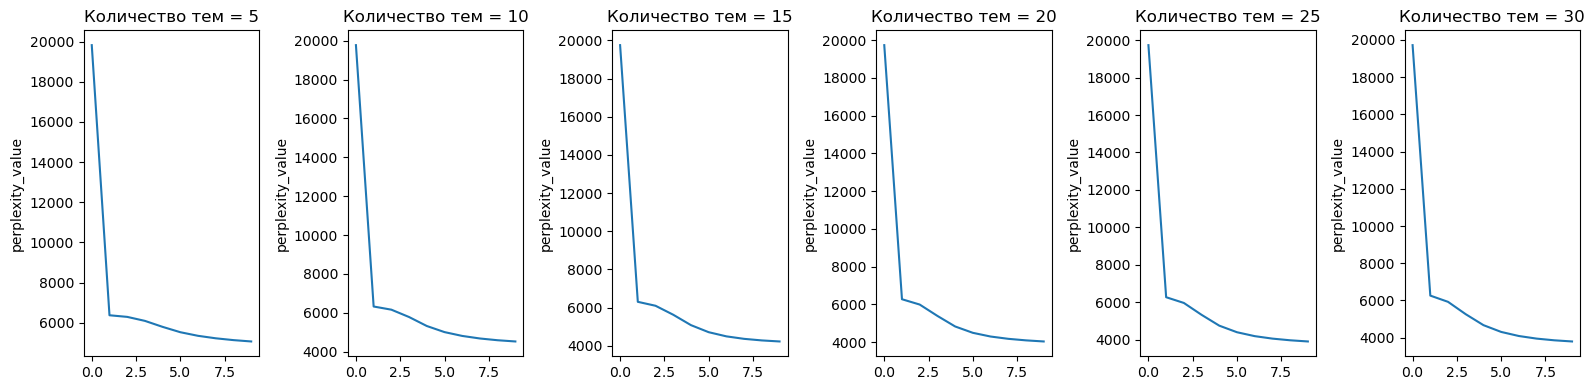

In [66]:
plt.figure(figsize=(16, 4))
for index, (num_topics, value) in enumerate(fit_results.items()):
    plt.subplot(1, 6, index+1)
    sns.lineplot(x=np.arange(len(value["perplexity_value"])), y=value["perplexity_value"]);
    plt.title("Количество тем = {}".format(num_topics));
    plt.ylabel("perplexity_value");

plt.tight_layout()
plt.show()

In [67]:
# Выбираем 20, т.к перплексия не сильно отлчиается от 20 и 30
best_model = fit_results[20]["model"]

## Результаты

In [68]:
best_model.get_theta().head()

,16000,16001,16002,16003,16004,16005,16006,16007,16008,16009,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
topic_0,0.015717,0.737106,0.000821,0.431670,0.000705,0.001112,0.001150,0.001915,0.001754,0.082401,...,0.071602,0.001751,0.000910,0.001259,0.001227,0.024613,0.001004,0.001735,0.000540,0.302381
topic_1,0.275684,0.003140,0.006341,0.008213,0.004690,0.001266,0.085941,0.001630,0.000698,0.001088,...,0.001222,0.000308,0.003877,0.009477,0.003304,0.022900,0.001585,0.000573,0.021518,0.045326
topic_2,0.008788,0.005031,0.002443,0.001698,0.002735,0.000597,0.499873,0.002561,0.002963,0.047799,...,0.031698,0.000502,0.040136,0.099365,0.078702,0.199190,0.004761,0.000499,0.001012,0.001277
topic_3,0.000385,0.000508,0.056461,0.001935,0.004015,0.022310,0.001124,0.007631,0.027392,0.029800,...,0.004680,0.436461,0.001080,0.001934,0.001380,0.007330,0.310042,0.010839,0.012234,0.036050
topic_4,0.059234,0.005766,0.002100,0.032848,0.137509,0.734186,0.001048,0.002074,0.002710,0.129232,...,0.020710,0.000687,0.001596,0.012162,0.001607,0.259661,0.005646,0.291887,0.505436,0.037221


In [69]:
best_model.phi_.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
август,0.000050,0.000253,0.000017,1.017649e-04,2.763069e-04,6.891529e-04,4.261436e-04,0.000119,0.000077,0.000135,0.000462,1.157408e-05,2.785770e-04,9.200012e-05,9.095568e-04,0.000123,0.000165,2.896496e-04,4.215377e-04,0.000212
август год,0.000009,0.000056,0.000002,1.276921e-05,9.426116e-05,1.723023e-04,1.670535e-04,0.000003,0.000003,0.000026,0.000049,9.151917e-06,4.922877e-05,1.162025e-05,3.209413e-04,0.000013,0.000017,3.144865e-05,6.750338e-05,0.000065
ад,0.000004,0.000088,0.000062,7.732876e-08,1.970702e-05,2.117973e-05,1.700563e-05,0.000081,0.000098,0.000040,0.000018,5.497183e-07,1.164514e-07,3.086934e-08,1.696055e-05,0.000151,0.000001,2.955633e-08,9.119332e-08,0.000064
бабушка,0.000020,0.002816,0.000105,3.460869e-08,8.525212e-08,1.391421e-07,3.202975e-05,0.000372,0.000040,0.000007,0.000005,3.004514e-08,2.426677e-05,1.093872e-05,6.328895e-08,0.000121,0.000036,7.649019e-08,3.575584e-06,0.000087
берег,0.000021,0.000017,0.000012,7.261764e-06,2.078763e-06,9.341713e-05,1.305518e-07,0.000050,0.000020,0.000022,0.000076,5.794546e-06,1.200455e-07,4.182533e-06,5.496408e-05,0.000463,0.001558,4.328731e-05,7.797876e-06,0.000002


In [70]:
top_tokens = best_model.get_top_tokens(num_tokens=10)

for i, token_list in enumerate(top_tokens):
    print('Topic #{0}: {1}'.format(i+1, token_list))

Topic #1: ['вода', 'система', 'случай', 'специалист', 'должный', 'учёный', 'очень', 'исследование', 'работа', 'организм']
Topic #2: ['ребёнок', 'семья', 'дом', 'отец', 'жить', 'мама', 'сын', 'знать', 'очень', 'жена']
Topic #3: ['сказать', 'песня', 'знать', 'жизнь', 'делать', 'концерт', 'ваш', 'думать', 'дело', 'новый']
Topic #4: ['новый', 'москва', 'проект', 'город', 'работа', 'развитие', 'строительство', 'центр', 'вопрос', 'решение']
Topic #5: ['страна', 'российский', 'государство', 'экономика', 'власть', 'экономический', 'уровень', 'кризис', 'общество', 'рост']
Topic #6: ['украина', 'самолёт', 'российский', 'дело', 'крым', 'мк', 'полиция', 'страна', 'киев', 'мвд']
Topic #7: ['суд', 'дело', 'адвокат', 'уголовный', 'право', 'решение', 'судья', 'деньга', 'следователь', 'следствие']
Topic #8: ['ребёнок', 'школа', 'родитель', 'детский', 'жизнь', 'нужный', 'класс', 'образование', 'работать', 'учитель']
Topic #9: ['фильм', 'театр', 'очень', 'жизнь', 'роль', 'режиссёр', 'картина', 'актёр', '

## Тестовая выборка LDA

In [71]:
theta_test = best_model.transform(test_batch_vectorizer)

In [72]:
theta_test

,0,1,2,3,4,5,6,7,8,9,...,747,748,749,750,751,752,753,754,755,756
topic_0,0.411643,0.014674,0.024486,0.001099,0.002100,0.001187,0.011534,0.006158,0.006806,0.106782,...,0.253256,0.006974,0.019594,0.005825,0.004172,0.002289,0.003613,0.036812,0.001492,0.006910
topic_1,0.001531,0.000593,0.000558,0.002847,0.045623,0.160768,0.043788,0.002833,0.000747,0.000460,...,0.153571,0.463871,0.254008,0.071773,0.019727,0.123249,0.000963,0.027561,0.379370,0.097724
topic_2,0.077910,0.011393,0.000882,0.399121,0.048404,0.075394,0.002499,0.021711,0.001157,0.000540,...,0.066495,0.004666,0.039481,0.021338,0.015098,0.016945,0.001820,0.049843,0.071048,0.305360
topic_3,0.095297,0.009137,0.045180,0.002493,0.006048,0.004848,0.010223,0.198134,0.001076,0.303403,...,0.011433,0.005952,0.059118,0.001577,0.032402,0.001267,0.003022,0.048739,0.006381,0.003791
topic_4,0.051772,0.030889,0.000975,0.005368,0.062823,0.003807,0.000800,0.042222,0.569189,0.006085,...,0.020270,0.001876,0.001711,0.001317,0.273990,0.018757,0.001103,0.000649,0.001891,0.087598
topic_5,0.010786,0.153339,0.000991,0.025725,0.047656,0.060683,0.006055,0.005525,0.006011,0.092085,...,0.000410,0.011829,0.051018,0.044061,0.035444,0.007758,0.001015,0.012892,0.011984,0.113531
topic_6,0.002143,0.081766,0.000635,0.001413,0.443123,0.127365,0.000437,0.308107,0.000809,0.000403,...,0.000936,0.004130,0.216550,0.383700,0.008366,0.019011,0.000901,0.000447,0.016050,0.035882
topic_7,0.004394,0.001356,0.000698,0.002281,0.003858,0.007816,0.284497,0.000805,0.000978,0.000613,...,0.276262,0.071289,0.016501,0.011073,0.000920,0.001874,0.000768,0.034333,0.030160,0.013175
topic_8,0.003856,0.001478,0.000809,0.138533,0.006473,0.005372,0.003539,0.188160,0.000611,0.002385,...,0.002240,0.001230,0.018857,0.031377,0.004113,0.542468,0.000910,0.033271,0.068296,0.107841
topic_9,0.057682,0.001314,0.049791,0.107937,0.016992,0.049456,0.000928,0.001582,0.011703,0.040053,...,0.001410,0.083698,0.002640,0.002653,0.012977,0.000818,0.002060,0.004372,0.003011,0.001620


# ARTM

In [73]:
artm_model = artm.ARTM(
    num_topics=25,
    cache_theta=True,
    scores=[artm.PerplexityScore(name="PerplexityScore", dictionary=batch_vectorizer.dictionary), artm.TopTokensScore(name='top_tokens_score')],
    regularizers=[
        artm.SmoothSparseThetaRegularizer(name="SparseTheta", tau=-0.15),
        artm.SmoothSparsePhiRegularizer(name="SparsePhi", tau=-0.1),            # контролирует разреженность Phi
        artm.DecorrelatorPhiRegularizer(name="DecorrelatorPhi", tau=0.05),      # уменьшает корреляцию между темами
        # artm.ImproveCoherencePhiRegularizer(name="ImproveCoherencePhi", tau=0.1) # повышает связность тем
    ]
)

In [74]:
artm_model.initialize(dictionary=batch_vectorizer.dictionary)

In [75]:
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [76]:
artm_perplexity_score = artm_model.score_tracker["PerplexityScore"].value
top_tokens = artm_model.score_tracker['top_tokens_score']

In [77]:
print("Последнее значение перплексии: {:.2f}".format(artm_perplexity_score[-1]))

Последнее значение перплексии: 3910.18


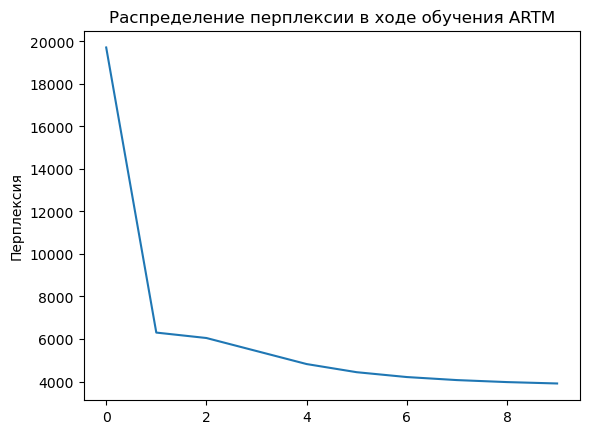

In [78]:
sns.lineplot(x=np.arange(len(artm_perplexity_score)), y=artm_perplexity_score)
plt.ylabel("Перплексия")
plt.title("Распределение перплексии в ходе обучения ARTM")
plt.show()

In [79]:
for topic_name in artm_model.topic_names:
    print(topic_name + ': ', top_tokens.last_tokens[topic_name])

topic_0:  ['учёный', 'вода', 'исследование', 'специалист', 'система', 'случай', 'должный', 'продукт', 'организм', 'очень']
topic_1:  ['ребёнок', 'семья', 'дом', 'мама', 'жить', 'сын', 'отец', 'знать', 'жена', 'муж']
topic_2:  ['сказать', 'песня', 'концерт', 'знать', 'жизнь', 'музыка', 'артист', 'новый', 'делать', 'дело']
topic_3:  ['новый', 'москва', 'проект', 'город', 'строительство', 'центр', 'работа', 'развитие', 'объект', 'московский']
topic_4:  ['выбор', 'партия', 'власть', 'страна', 'государство', 'политический', 'общество', 'единый', 'член', 'считать']
topic_5:  ['дело', 'украина', 'преступление', 'полиция', 'мк', 'уголовный', 'сотрудник', 'убийство', 'задержать', 'мвд']
topic_6:  ['суд', 'дело', 'адвокат', 'решение', 'право', 'судья', 'судебный', 'слово', 'вопрос', 'заявление']
topic_7:  ['ребёнок', 'школа', 'родитель', 'детский', 'образование', 'класс', 'учитель', 'жизнь', 'работать', 'учиться']
topic_8:  ['фильм', 'театр', 'очень', 'жизнь', 'роль', 'режиссёр', 'картина', 'кин

## Тестовая выборка ARTM

In [80]:
theta_test_artm = artm_model.transform(batch_vectorizer=test_batch_vectorizer)

In [81]:
theta_test_artm

,0,1,2,3,4,5,6,7,8,9,...,747,748,749,750,751,752,753,754,755,756
topic_0,0.306024,0.009974,0.008425,0.000000,0.000394,0.000000,0.014403,0.005098,0.005427,0.034792,...,0.227157,0.006573,0.038109,0.006836,0.001732,0.000000,0.002356,0.037486,0.000730,0.000000
topic_1,0.000046,0.000000,0.000000,0.000000,0.046259,0.198527,0.058424,0.000000,0.000000,0.000000,...,0.202280,0.483176,0.262982,0.102899,0.017919,0.099342,0.000505,0.030111,0.366731,0.099615
topic_2,0.026205,0.007395,0.000000,0.418796,0.033530,0.034936,0.004516,0.000626,0.000000,0.000000,...,0.029541,0.001189,0.030064,0.018431,0.017669,0.014909,0.000200,0.029381,0.057494,0.161106
topic_3,0.054394,0.000917,0.102251,0.000000,0.001028,0.003941,0.031023,0.114175,0.000000,0.297254,...,0.006331,0.004844,0.033938,0.000000,0.017377,0.000000,0.001536,0.054410,0.004807,0.000000
topic_4,0.003896,0.012247,0.000000,0.000000,0.005146,0.009897,0.000000,0.034629,0.006542,0.000000,...,0.013125,0.000000,0.000000,0.000000,0.254998,0.029042,0.000000,0.002357,0.000210,0.048659
topic_5,0.000421,0.069476,0.000000,0.019145,0.151863,0.137849,0.000000,0.013092,0.003166,0.000397,...,0.000000,0.011418,0.127252,0.103416,0.010888,0.009650,0.000012,0.000000,0.022159,0.145960
topic_6,0.000432,0.083158,0.000000,0.000000,0.318603,0.082015,0.000000,0.299724,0.000000,0.000000,...,0.000707,0.001918,0.158667,0.363248,0.010300,0.011763,0.000000,0.000000,0.011248,0.000000
topic_7,0.000182,0.000000,0.000000,0.000000,0.000676,0.000525,0.284096,0.000000,0.000000,0.000000,...,0.163073,0.047025,0.012295,0.000000,0.000000,0.000000,0.000000,0.008769,0.012852,0.002969
topic_8,0.001616,0.000000,0.000000,0.149797,0.004009,0.002884,0.000000,0.178363,0.000000,0.000717,...,0.001052,0.000000,0.005479,0.020406,0.002285,0.541551,0.000000,0.023855,0.062882,0.038772
topic_9,0.059241,0.000000,0.072223,0.112216,0.004749,0.058379,0.000035,0.000000,0.016920,0.035508,...,0.001825,0.078221,0.000000,0.000000,0.013101,0.000000,0.000346,0.001552,0.000141,0.000000
